In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pprint

from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, CG
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, HFMethodType

In [2]:
global qubit_mapping
qubit_mapping = 'jordan_wigner'
global two_qubit_reduction
two_qubit_reduction = False
global best_result
global hfmethod
hfmethod = HFMethodType.ROHF
global var_form
global vqe
global ferOp

In [7]:
backend = Aer.get_backend("statevector_simulator")
optimizer = COBYLA(maxiter=500)
distances = np.arange(0.5, 3, 0.1)
vqe_energies = []
min = 100.0
dismin = 0.0

for dist in distances:
    charge = 1
    spin = 2   
    alt=np.sqrt(dist**2 - (dist/2)**2)
    mol = "H .0 .0 .0; H .0 .0 " + str(dist) + "; H .0 " + str(alt) + " " + str(dist/2)
    driver = PySCFDriver(atom = mol,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis='sto-6g',hf_method=hfmethod)
    
    molecule = driver.run()
    
    shift = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = molecule.num_orbitals
    num_spin_orbitals = num_orbitals*2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    
    qubitOp = ferOp.mapping(map_type=qubit_mapping)
    
    initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction)
    
    init_parm = np.zeros(var_form.num_parameters)
    vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm)
    vqe_result_tot = vqe.run(backend)
    vqe_result = np.real(vqe_result_tot['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), 
          "VQE Result:", vqe_result)
    if vqe_result < min:
        min = vqe_result
        dismin = dist
        best_result = vqe_result_tot

Interatomic Distance: 0.5 VQE Result: -0.752780559340124
Interatomic Distance: 0.6 VQE Result: -1.0251056982904094
Interatomic Distance: 0.7 VQE Result: -1.1699429347915227
Interatomic Distance: 0.8 VQE Result: -1.2433091976607973
Interatomic Distance: 0.9 VQE Result: -1.2748268158680711
Interatomic Distance: 1.0 VQE Result: -1.2811879870428409
Interatomic Distance: 1.1 VQE Result: -1.2722647616188205
Interatomic Distance: 1.2 VQE Result: -1.2541320863958747
Interatomic Distance: 1.3 VQE Result: -1.2306719058782376
Interatomic Distance: 1.4 VQE Result: -1.2044585634762532
Interatomic Distance: 1.5 VQE Result: -1.1772556461617938
Interatomic Distance: 1.6 VQE Result: -1.1502958834885646
Interatomic Distance: 1.7 VQE Result: -1.1244398862657885
Interatomic Distance: 1.8 VQE Result: -1.1002689484912729
Interatomic Distance: 1.9 VQE Result: -1.0781444681500578
Interatomic Distance: 2.0 VQE Result: -1.0582520330955338
Interatomic Distance: 2.1 VQE Result: -1.0406387304999192
Interatomic Dis

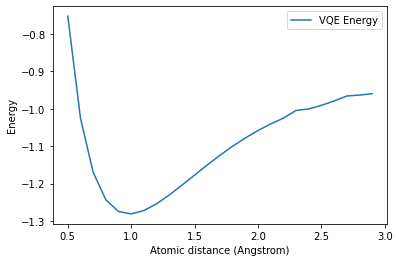

In [8]:
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
#plt.ylim([-1.5, -1.3])
plt.show()

In [6]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(best_result)

{   'cost_function_evals': 123,
    'eigenstate': array([-1.17094664e-16+1.09359698e-16j, -5.86975747e-16+1.06055488e-15j,
        7.51219849e-17+7.44336504e-17j,  5.20159447e-17+7.08089542e-17j,
       -2.91774751e-17-7.08113993e-17j,  8.68032590e-17+6.49829836e-17j,
        3.48527661e-17-1.13436945e-16j,  7.25294372e-17-5.34801183e-17j,
       -4.45785160e-16+8.62405717e-16j,  9.97001467e-01-7.81108239e-15j,
        8.42338511e-03+8.10562199e-17j,  3.89835706e-16+5.94382362e-16j,
       -6.41873868e-06+9.92494802e-17j,  5.83833735e-16+6.10731302e-16j,
        4.14621861e-17-7.22838264e-17j, -8.91426645e-17-1.40801050e-16j,
        3.85852601e-17+6.09446637e-17j,  8.46523777e-03-1.33885403e-16j,
       -5.40510791e-02+3.68245773e-16j, -9.81969514e-18-4.28292951e-17j,
       -6.08826405e-05+1.05129757e-16j,  5.64300143e-17+1.29424735e-17j,
       -5.53588045e-17-4.10028139e-17j, -1.26766858e-17+5.64268281e-17j,
       -1.48247074e-16-4.40662122e-17j,  5.61338141e-16+5.60608122e-16j,
 

In [48]:
pp.pprint(ferOp.mapping(qubit_mapping).simplify().print_details())

('IIIIII\t(-1.9399515378361785+0j)\n'
 'IIIIIZ\t(0.3665168794494104+0j)\n'
 'IIIIYY\t(-0.0053160559104534185+0j)\n'
 'IIIIXX\t(-0.0053160559104534185+0j)\n'
 'IIIIZI\t(-0.291993836783662+0j)\n'
 'IIIZII\t(-0.2920367496903666+0j)\n'
 'IIZIII\t(0.3665168794494105+0j)\n'
 'IYYIII\t(-0.0053160559104534185+0j)\n'
 'IXXIII\t(-0.0053160559104534185+0j)\n'
 'IZIIII\t(-0.29199383678366203+0j)\n'
 'ZIIIII\t(-0.2920367496903667+0j)\n'
 'IIIIZZ\t(0.13435833692115612+0j)\n'
 'IIIZIZ\t(0.1343589364542294+0j)\n'
 'IIIZYY\t(7.427022718487159e-05+0j)\n'
 'IIIZXX\t(7.427022718487159e-05+0j)\n'
 'IIZIIZ\t(0.17580800300172073+0j)\n'
 'IIZIYY\t(0.0005597918131280862+0j)\n'
 'IIZIXX\t(0.0005597918131280862+0j)\n'
 'IIZYZY\t(3.1180400425159826e-06+0j)\n'
 'IIZXZX\t(3.1180400425159826e-06+0j)\n'
 'IXXIIZ\t(0.0005597918131280862+0j)\n'
 'IYYIIZ\t(0.0005597918131280862+0j)\n'
 'IXXIYY\t(0.03688199734099208+0j)\n'
 'IYYIYY\t(0.03688199734099208+0j)\n'
 'IXXIXX\t(0.03688199734099208+0j)\n'
 'IYYIXX\t(0.0368819973

In [4]:
var_form.single_excitations 

[[0, 1], [0, 2], [3, 4], [3, 5]]

In [5]:
var_form.double_excitations

[[0, 1, 3, 4], [0, 1, 3, 5], [0, 2, 3, 4], [0, 2, 3, 5]]